Build a DNN that compares two MNIST digit images and predicts whether they represent the same digit or not.

In [508]:
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

import time
import random

def display_matrix(X, row=None, size=28):
    X_data = np.array([])
    if row is None:
        row = np.sqrt(len(X))
    for x in X:
        arr = x.reshape(size,size)
        if X_data.any() :
            X_data = np.concatenate( (X_data, arr), axis=1  )
        else:
            X_data = arr
    n = np.array_split(X_data, row, axis=1)
    X_data = np.concatenate(n, axis=0)
    plt.imshow(X_data, interpolation="nearest", cmap=plt.get_cmap('gray'))
    plt.axis("off")
    plt.show()

data : 

In [509]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

create a couple of image (50% same, 50% not same) : 

In [374]:
def couple_image(X_train, y_train):
    ck = {5:[], 6:[], 7:[], 8:[], 9:[], 0:[], 1:[], 2:[], 3:[], 4:[]}
    for i, v in enumerate(y_train):
        ck[v].append(i)
    
    d_same_a = []
    d_same_b = []
    labels = []
    for x in range(27500):
        v = random.randint(0,9)
        d_same_a.append(X_train[ck[v][random.randint(0,len(ck[v])-1)]])
        d_same_b.append(X_train[ck[v][random.randint(0,len(ck[v])-1)]])
        labels.append(1)
    
    d_nsame_a = []
    d_nsame_b = []
    for x in range(27500):
        l = [0,1,2,3,4,5,6,7,8,9]
        a = random.randint(0,9)
        l.pop(a)
        b = random.choice(l)
        
        d_nsame_a.append(X_train[ck[a][random.randint(0,len(ck[a])-1)]])
        d_nsame_b.append(X_train[ck[b][random.randint(0,len(ck[b])-1)]])
        labels.append(0)
    
    return np.array(d_same_a), np.array(d_same_b), np.array(d_nsame_a), np.array(d_nsame_b), np.array(labels).reshape(-1,1)

In [375]:
da, db, nda, ndb, y_labels = couple_image(X_train, y_train)

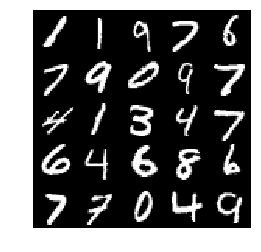

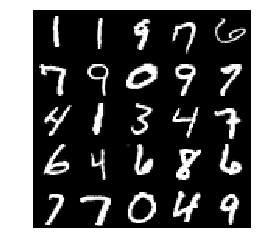

In [135]:
# ------- SAME -------
display_matrix(da[0:25])
display_matrix(db[0:25])

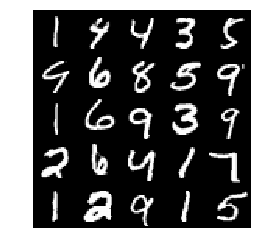

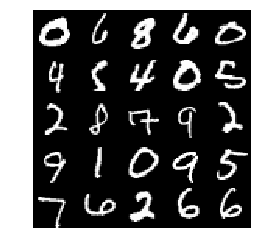

In [136]:
# ------- NOT SAME -------
display_matrix(nda[0:25])
display_matrix(ndb[0:25])

In [200]:
#perfect, now concat :
X_train_a = np.concatenate([da, nda])
X_train_b = np.concatenate([db, ndb])
y_labels = y_labels

In [335]:
X_train_all = np.concatenate(([X_train_a], [X_train_b]), axis=0)

In [368]:
X_train_all.shape

(55000, 2, 784)

In [343]:
X_train_all = X_train_all.reshape(55000,2,784)

params : 

In [544]:
n_hidden = 100
n_input = 28*28
last_hidden = 10
lr = 0.001
n_epochs = 35
n_outputs = 1
batch_size = 500

In [545]:
tf.reset_default_graph()
he_init = tf.contrib.layers.variance_scaling_initializer()

y = tf.placeholder(tf.int32, shape=[None,1])

X = tf.placeholder(tf.float32, shape=(None, 2, n_input), name="X")
X_a, X_b = tf.unstack(X, axis=1)

# DNN A 
#X_a = tf.placeholder(tf.float32, shape=(None, n_input), name="X_a")
#y_a = tf.placeholder(tf.int32, shape=(None), name="y")

 # Initialisation de He
hidden1_a = tf.layers.dense(X_a, n_hidden, activation=tf.nn.elu, name="hidden1_a", kernel_initializer=he_init)
hidden2_a = tf.layers.dense(hidden1_a, n_hidden, activation=tf.nn.elu, name="hidden2_a", kernel_initializer=he_init)
hidden3_a = tf.layers.dense(hidden2_a, n_hidden, activation=tf.nn.elu, name="hidden3_a", kernel_initializer=he_init)
hidden4_a = tf.layers.dense(hidden3_a, n_hidden, activation=tf.nn.elu, name="hidden4_a", kernel_initializer=he_init)
hidden5_a = tf.layers.dense(hidden4_a, n_hidden, activation=tf.nn.elu, name="hidden5_a", kernel_initializer=he_init)
#hidden6_a = tf.layers.dense(hidden5_a, last_hidden, activation=tf.nn.elu, name="hidden6_a", kernel_initializer=he_init)

# DNN A 
#X_b = tf.placeholder(tf.float32, shape=(None, n_input), name="X_b")
#y_b = tf.placeholder(tf.int32, shape=(None), name="y")

hidden1_b = tf.layers.dense(X_b, n_hidden, activation=tf.nn.elu, name="hidden1_b", kernel_initializer=he_init)
hidden2_b = tf.layers.dense(hidden1_b, n_hidden, activation=tf.nn.elu, name="hidden2_b", kernel_initializer=he_init)
hidden3_b = tf.layers.dense(hidden2_b, n_hidden, activation=tf.nn.elu, name="hidden3_b", kernel_initializer=he_init)
hidden4_b = tf.layers.dense(hidden3_b, n_hidden, activation=tf.nn.elu, name="hidden4_b", kernel_initializer=he_init)
hidden5_b = tf.layers.dense(hidden4_b, n_hidden, activation=tf.nn.elu, name="hidden5_b", kernel_initializer=he_init)
#hidden6_b = tf.layers.dense(hidden5_b, last_hidden, activation=tf.nn.elu, name="hidden6_b", kernel_initializer=he_init)

In [546]:
concat = tf.concat([hidden5_a, hidden5_b], axis=1, name="concat")
hidden_6 = tf.layers.dense(concat, last_hidden, activation=tf.nn.elu, name="hidden_6", kernel_initializer=he_init)

In [547]:
logits = tf.layers.dense(hidden_6, n_outputs, name="logits", kernel_initializer=he_init)

y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

In [548]:
#xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)  # entropie croisée
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

#loss = tf.reduce_mean(logits, name="loss")  # loss

In [549]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

In [550]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

dataset test :

In [551]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

training : 

In [552]:
X_test_b, y_test_b = generate_batch(X_test, y_test, batch_size=len(X_test))
X_valid_b, y_valid_b = generate_batch(X_valid, y_valid, batch_size=len(X_valid))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        init.run()
        for epoch in range(n_epochs):
            for iteration in range(len(X_train) // batch_size):
                X_batch, y_batch = generate_batch(X_train, y_train, batch_size)
                sess.run([loss, training_op], feed_dict={X: X_batch, y:y_batch})
            #train_s_a =  np.array_split(X_train_a, len(X_train_a) // batch_size)
            #train_s_b =  np.array_split(X_train_b, len(X_train_b) // batch_size)
            #y_labels_s = np.array_split(y_labels, len(y_labels) // batch_size)
            #for x in range(len(train_s_a)):
            #sess.run([loss, training_op], feed_dict={X_a: train_s_a[x], X_b:train_s_b[x], y: y_labels_s[x]})
            
            #X_train_all, y_labels = shuffle(X_train_all, y_labels)
            
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y:y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid_b, y:y_valid_b})
            
            print(epoch, "Training accuracy:", acc_batch, "Validation accuracy : ", acc_valid)
        saver.save(sess, "/Users/yannis/Developpement/DeepLearning/save/RNP-predict/mymodel")

0 Training accuracy: 0.832 Validation accuracy :  0.7938
1 Training accuracy: 0.834 Validation accuracy :  0.858
2 Training accuracy: 0.868 Validation accuracy :  0.8782
3 Training accuracy: 0.878 Validation accuracy :  0.8974
4 Training accuracy: 0.912 Validation accuracy :  0.9148
5 Training accuracy: 0.92 Validation accuracy :  0.9268
6 Training accuracy: 0.932 Validation accuracy :  0.9334
7 Training accuracy: 0.93 Validation accuracy :  0.9382
8 Training accuracy: 0.942 Validation accuracy :  0.9448
9 Training accuracy: 0.936 Validation accuracy :  0.9456
10 Training accuracy: 0.952 Validation accuracy :  0.9506
11 Training accuracy: 0.974 Validation accuracy :  0.9526
12 Training accuracy: 0.936 Validation accuracy :  0.9538
13 Training accuracy: 0.956 Validation accuracy :  0.9588
14 Training accuracy: 0.952 Validation accuracy :  0.9614
15 Training accuracy: 0.962 Validation accuracy :  0.9614
16 Training accuracy: 0.964 Validation accuracy :  0.9618
17 Training accuracy: 0.978

#### Test : 

In [554]:
with tf.Session() as sess:
    saver.restore(sess, "/Users/yannis/Developpement/DeepLearning/save/RNP-predict/mymodel")
    accuracy_val = accuracy.eval(feed_dict={X: X_test_b, y: y_test_b})
    print("Accuracy test dataset : ", accuracy_val)

INFO:tensorflow:Restoring parameters from /Users/yannis/Developpement/DeepLearning/save/RNP-predict/mymodel
Accuracy test dataset :  0.9672


All right, we reach 96.72% accuracy on this digit comparison task

In [563]:
v1 = random.randint(0,len(X_test))
v2 = random.randint(0,len(X_test))

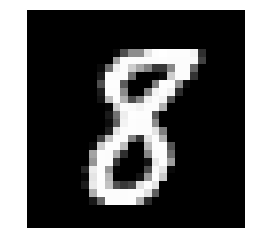

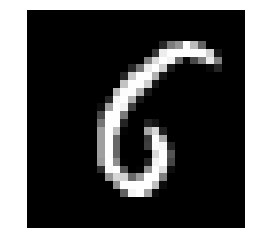

In [566]:
display_matrix(X_test[v1:v1+1])
display_matrix(X_test[v2:v2+1])

In [585]:
with tf.Session() as sess:
    saver.restore(sess, "/Users/yannis/Developpement/DeepLearning/save/RNP-predict/mymodel")
    
    test = np.array([np.concatenate([X_test[v1:v1+1],X_test[v2:v2+1]], axis=0)])
    
    pred = y_pred.eval(feed_dict={X: test })
    print(" ")
    print(pred)
    
    if pred[0][0] == 0:
        print("NO THE SAME NUMBER")
    else:
        print("SAME NUMBER")
    #print("Accuracy test dataset : ", accuracy_val)

INFO:tensorflow:Restoring parameters from /Users/yannis/Developpement/DeepLearning/save/RNP-predict/mymodel
 
[[0]]
NO THE SAME NUMBER
